# Assignment 4: Search Objects In A Video Footage - kelvin.ahiakpor & emmanuel.acquaye

## Computer Vision

### Streamlit App

You can interact with the complete app through the following link:

[Search Objects In A Video Footage](https://searchobjects-in-a-footage.streamlit.app)

### Imports

In [1]:
import os
import cv2
import time
import threading
import numpy as np
import pandas as pd
import tensorflow as tf
import ipywidgets as widgets  
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing import image
from IPython.display import display, clear_output, Javascript, Image as IPImage
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input,decode_predictions

### Setting job timeout for computation

In [2]:
os.environ['JOBLIB_START_METHOD'] = 'loky'
os.environ['JOBLIB_TIMEOUT'] = '300'

### Custom recipes for DataFrame inspection
Object predictions will be stored in a dataframe so it can be displayed in a friendly manner in this notebook

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3) 

# Task 1
Use a pretrained Google Inception V3 deep learning model

Downloading the pretrained weights from the ImageNet dataset which for our image classifcation purposes

In [4]:
model = InceptionV3(weights='imagenet')

**Defining a function to preprocess images for InceptionV3**

In [5]:
def preprocess_frame(frame_path):
    img = image.load_img(frame_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = preprocess_input(x)
    return x

**Defining a function to get top 5 predictions for each frame**

In [6]:
def get_predictions(frame_path):
    x = preprocess_frame(frame_path)
    preds = model.predict(x)
    return decode_predictions(preds, top=5)[0]

## Task 2 
Ensure the implementation is general enough to accept any user-provided video

**Accepting all video formats**  

In [7]:
accepted_formats = 'video/*'

## Task 3
Allow users to upload videos through Colab or any other method  

Here we define **3** sets of functions to allow uploads whether this notebook is run in Colab or Jupyter  
**1** The first takes user input and runs the desired upload method  
**2** The second set of functions handles uploads from Google Colab  
**3** The third set handles uploads from Jupyter   

Eventually we deploy in Streamlit where we can have even more upload generalization capabilities  
**Note:** The technique used is handling imports in the function to dynamically import modules based on dependencies determined by runtime conditions

**Setting a video size threshold of 200MB**

In [8]:
memory_size_threshold = 200 * 1024 * 1024  # 100 MB

**Global variables**  
Dictionary of upload information   
Video path  
Upload Widget
Upload Status

In [9]:
upload_info = None
video_path = None

In [10]:
upload_completed = False

**Widget creation**

In [11]:
upload_widget = widgets.FileUpload(accept=accepted_formats, multiple=False)
upload_button = widgets.Button(description="Process Upload")

**Function Set 1**

In [12]:
def select_run_choice():
    global video_path
    while True:
        choice = input("Enter '1' for Google Colab upload or '2' for Jupyter upload." + 
                       " 2 is recommended however as it works across platforms : ")
        if choice == '1':
            clear_output(wait=False)
            video_path = upload_files_colab()
            break
        elif choice == '2':
            clear_output(wait=False)
            show_upload_widget() 
            break
        else:
            print("Invalid choice. Please enter '1' or '2'.")

**Function Set 2 (Google Colab)**

In [13]:
def handle_file_upload_colab(uploaded_files, memory_size_threshold):
    global video_path
    for filename in uploaded_files.keys():
        file_size = len(uploaded_files[filename])
        if file_size > memory_size_threshold:
            print(f'The file "{filename}" exceeds the memory size threshold of {memory_size_threshold / (1024 * 1024)} MB.')
            return None
        else:
            video_path = list(uploaded.keys())[0]
            print(f'User uploaded file "{filename}" with size {file_size} bytes')
            return filename  # Return the filename for further processing

In [14]:
def upload_files_colab():
    from google.colab import files  # Import inside the function to avoid platform crash
    uploaded = files.upload()
    filename = handle_file_upload_colab(uploaded, memory_size_threshold)
    return filename

**Function Set 3 (Jupyter)**

In [15]:
def validate_file_upload(uploaded_files, memory_size_threshold):
    for filename, file_info in uploaded_files.items():
        file_size = file_info['metadata']['size']
        if file_size > memory_size_threshold:
            print(f'The file "{filename}" exceeds the memory size threshold of {memory_size_threshold / (1024 * 1024)} MB.')
            return None  # Indicates that the file is too large
        else:
            print(f'User uploaded file "{filename}" with size {file_size} bytes')
            save_file_jupyter(filename, file_info['content'])
            return filename  # Indicates that the file is within the limit

In [16]:
def save_file_jupyter(filename, file_content):
    with open(filename, 'wb') as f:
        f.write(file_content)
    print(f'File "{filename}" has been saved.')

In [17]:
def process_files(button):
    global upload_completed
    global video_path
    clear_output(wait=False)
    uploaded_files = upload_widget.value
    # Handle file validation and save
    video_path = validate_file_upload(uploaded_files, memory_size_threshold)
    if video_path:
        print(f"Video path set to: {video_path}")
        upload_completed = True  # Mark the upload as complete
    else:
        print("No valid video file uploaded.")
    
    if upload_completed:
        print()
        print("Upload complete. You can now proceed to the run the next cells.")

In [18]:
def show_upload_widget():
    global upload_button
    upload_button = widgets.Button(description="Upload Video")
    upload_button.on_click(process_files)
    
    # Display the widgets
    display(upload_widget)
    display(upload_button)
    
    print("Please upload a file and then click the 'Upload Video' button.")
    wait_for_video()

**Defining a function to wait for video**  
Lets kernel wait 15 seconds for video

In [19]:
def wait_for_video():
    print("Waiting for file upload...")
    print("You have 15 seconds to upload your video")
    print("If you have already uploaded and clicked 'Upload Video' please be patient.")
    print()
    count = 1
    while not upload_completed:
        time.sleep(3)  # Check every 3 seconds
        print(f"{15 - (count*3)} seconds left...")
        count+=1
        if count == 5:
            raiseBreak()
    if video_path:
        print("File upload detected. Proceeding with processing...")

**Creating and throwing an exception to halt execution and take user upload**

In [20]:
class VideoUploadBreak(Exception):
    def __init__(self, message="""The program has halted here to take video,  
    No video detected yet.
    Did you click 'Upload Video'?
    You can still go ahead even though the given time elapsed
    If you're using Jupyter, clicking the button should fix the issue.
    If you're using Google Colab, run this cell again after clicking the button`"""):
        self.message = message
        super().__init__(self.message)
    
    def __str__(self):
        return self.message

In [21]:
def raiseBreak():
    raise VideoUploadBreak()

Now we can allow user to upload video

**Allowing user to upload video**

In [22]:
select_run_choice()

User uploaded file "truck.MOV" with size 8881893 bytes
File "truck.MOV" has been saved.
Video path set to: truck.MOV

Upload complete. You can now proceed to the run the next cells.


## Task 4
Split the uploaded video into frames and feed the frames into the Google Inception V3 model to detect objects

In [23]:
def extract_frames(video_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    count = 0
    success, image = vidcap.read()
    while success:
        frame_path = os.path.join(output_folder, f"frame{count}.jpg")
        cv2.imwrite(frame_path, image)
        success, image = vidcap.read()
        count += 1
    return count

**Defining a function to clear output folder**  
We need to use this whenever user uploads a new video

In [24]:
def clear_output_folder(output_folder):
    if os.path.exists(output_folder):
        for file in os.listdir(output_folder):
            file_path = os.path.join(output_folder, file)
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)

**Extracting frames from the video and storing in a local output folder**  
Here we clear output folder before writing the frames of the new videe so the user's search only applies to the current video

In [25]:
output_folder = 'frames'
clear_output_folder(output_folder) #clearing output folder
frame_count = extract_frames(video_path, output_folder)
print(f'Extracted {frame_count} frames from the video.')

Extracted 68 frames from the video.


**Getting predictions**  
Here we pass the frames into InceptionV3 and store predictions for each frame in 2 dataframes  
One dataframe for details and one for summary

The loops in the next two cells retreive predictions and store in lists and dictionary

In [26]:
predictions_list = []

for i in tqdm(range(frame_count)):
    if i % 10 == 0: #reducing verbosity
        clear_output(wait=False)
        
    frame_path = os.path.join(output_folder, f"frame{i}.jpg")
    predictions = get_predictions(frame_path)
    for pred in predictions:
        code, object_name, score = pred
        predictions_list.append([frame_path, code, object_name, score])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|██████████████████████████████████████▌    | 61/68 [00:08<00:00,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████████▏   | 62/68 [00:08<00:00,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|███████████████████████████████████████▊   | 63/68 [00:08<00:00,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|████████████████████████████████████████▍  | 64/68 [00:08<00:00,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████████████████████████████████████  | 65/68 [00:08<00:00,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████████████████████████████████████▋ | 66/68 [00:08<00:00,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|██████████████████████████████████████████▎| 67/68 [00:08<00:00,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|███████████████████████████████████████████| 68/68 [00:09<00:00,  7.51it/s]


In [27]:
predictions_dict = {}
for i in tqdm(range(frame_count)):
    if i % 10 == 0: #reducing verbosity
        clear_output(wait=False)
        
    frame_path = os.path.join(output_folder, f"frame{i}.jpg")
    predictions = get_predictions(frame_path)
    objects = [pred[1] for pred in predictions]
    scores = [pred[2] for pred in predictions]
    predictions_dict[frame_path] = (objects, scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████████▌    | 61/68 [00:07<00:00,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████████▏   | 62/68 [00:07<00:00,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|███████████████████████████████████████▊   | 63/68 [00:07<00:00,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████████▍  | 64/68 [00:07<00:00,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████████████████████████████████████  | 65/68 [00:07<00:00,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████████▋ | 66/68 [00:07<00:00,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|██████████████████████████████████████████▎| 67/68 [00:07<00:00,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|███████████████████████████████████████████| 68/68 [00:07<00:00,  8.62it/s]


Here we store the predictions in a dataframe

In [28]:
object_predictions = pd.DataFrame(predictions_list, columns=['Frame', 'Class Code', 'Object', 'Score'])

In [29]:
object_predictions_summarized = pd.DataFrame([(frame, ', '.join(objs), ', '.join(map(str, scores))) 
                                   for frame, (objs, scores) in predictions_dict.items()],
                                  columns=['Frame', 'Objects', 'Scores'])

**Friendly displays of object predictions**

In [30]:
object_predictions_summarized.head(5)

,Frame,Objects,Scores
0,frames/frame0.jpg,"pickup, jeep, half_track, amphibian, golfcart","0.49122426, 0.33317998, 0.05761582, 0.014706732, 0.012436095"
1,frames/frame1.jpg,"pickup, jeep, half_track, car_wheel, golfcart","0.54946077, 0.34663907, 0.022582203, 0.016414924, 0.010969143"
2,frames/frame2.jpg,"pickup, jeep, half_track, golfcart, car_wheel","0.70105, 0.19161493, 0.023511218, 0.02341289, 0.007626943"
3,frames/frame3.jpg,"pickup, jeep, half_track, golfcart, car_wheel","0.53449863, 0.34069544, 0.022169843, 0.014197044, 0.008928447"
4,frames/frame4.jpg,"pickup, jeep, half_track, car_wheel, golfcart","0.49539608, 0.43080345, 0.020960132, 0.00544552, 0.003927359"


In [31]:
object_predictions.head(10)

,Frame,Class Code,Object,Score
0,frames/frame0.jpg,n03930630,pickup,0.491
1,frames/frame0.jpg,n03594945,jeep,0.333
2,frames/frame0.jpg,n03478589,half_track,0.058
3,frames/frame0.jpg,n02704792,amphibian,0.015
4,frames/frame0.jpg,n03445924,golfcart,0.012
5,frames/frame1.jpg,n03930630,pickup,0.549
6,frames/frame1.jpg,n03594945,jeep,0.347
7,frames/frame1.jpg,n03478589,half_track,0.023
8,frames/frame1.jpg,n02974003,car_wheel,0.016
9,frames/frame1.jpg,n03445924,golfcart,0.011


## Task 5
Allow users to type a search query for an object that might be in the uploaded video

In [32]:
def search_for_object(df, search_query):
    search_query = search_query.lower()
    results = df[df['Objects'].apply(lambda x: any(search_query in obj.lower() for obj in x.split(', ')))]
    return results

In [33]:
search_query = input("Enter the object you want to search for: ").strip().lower()

Enter the object you want to search for: truck


## Task 6
The application should return and display the frame(s) with the object searched by the user, if it exists. If the object doesn't exist, display an error message: "Object doesn't exist!!!".

**Defining a function to display a frame using matplotlib**

In [34]:
def display_frame(frame_path):
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.axis('off')
    plt.show()

**Defining a set of functions to display frames as gif**

First we define some important global variables  
`current_frame_index`,  `gif_path`, `frame_folder`, `previous button`, `next button`  

In [35]:
current_frame_index = 0

In [36]:
gif_path = 'search_results.gif'
frame_folder = 'frames' 

In [37]:
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

In [38]:
def create_gif(frame_folder, gif_path, duration=500):
    frames = []
    for filename in sorted(os.listdir(frame_folder)):
        if filename.endswith('.jpg'):
            frame_path = os.path.join(frame_folder, filename)
            frames.append(Image.open(frame_path))

    if frames:
        frames[0].save(
            gif_path,
            format='GIF',
            append_images=frames[1:],
            save_all=True,
            duration=duration,  # Duration in milliseconds
            loop=0  # Loop forever
        )

In [39]:
def display_gif():
    display(IPImage(filename=gif_path))

In [40]:
def display_frame_index(index, frame_paths):
    if 0 <= index < len(frame_paths):
        clear_output(wait=False)
        print(f"Displaying frame {index + 1} of {len(frame_paths)}")
        display_frame(frame_paths[index])
        display(prev_button)
        display(next_button)

Event handler click events for the buttons in the next 2 cells

In [41]:
def on_button_click(button):
    global current_frame_index
    if button.description == 'Next':
        current_frame_index = (current_frame_index + 1) % len(frame_paths)
    elif button.description == 'Previous':
        current_frame_index = (current_frame_index - 1) % len(frame_paths)
    display_frame_index(current_frame_index, frame_paths)

In [42]:
prev_button.on_click(on_button_click)
next_button.on_click(on_button_click)

**Display the GIF alongside next and previous buttons**

In [43]:
def display_frames_with_buttons(frame_paths):
    global current_frame_index
    current_frame_index = 0  # Initialize index

    # Display buttons for navigating frames
    display(prev_button)
    display(next_button)

    # Display the first frame
    display_frame_index(current_frame_index, frame_paths)

**Searching for objects**  
Using user input obtained earlier

In [44]:
search_results = search_for_object(object_predictions_summarized, search_query)

**Displaying frames containing search objects them if search was successful**

The gif is embedded in a markdown cell.  
If the search result has been updated enter the markdown cell and run it again to play the new one.  
This may show as a white question mark in a blue rectangle in markdown.

**Display gif**

In [45]:
if not search_results.empty:
    print(f'Found {search_query} in {len(search_results)} frames.')
    frame_paths = search_results['Frame'].tolist()
    print("Displaying as GIF:")
    create_gif(frame_folder, gif_path, duration=500)
else:
    print("Object doesn't exist!!!")

Found truck in 48 frames.
Displaying as GIF:


![result_gif](search_results.gif)

**Display frames with next and previous buttons**

Displaying frame 48 of 48


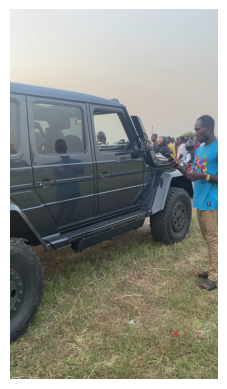

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

In [46]:
if not search_results.empty:
    print("You can cycle through the frames")
    frame_paths = search_results['Frame'].tolist()
    
    display_frames_with_buttons(frame_paths)

# References

**Bibliography**  
[1]Snowflake Inc. 2024. Connect Streamlit to Google Cloud Storage - Streamlit Docs. docs.streamlit.io. Retrieved July 19, 2024 from https://docs.streamlit.io/develop/tutorials/databases/gcs  
[2]Keras Team. 2024. Keras documentation: InceptionV3. keras.io. Retrieved July 19, 2024 from https://keras.io/api/applications/inceptionv3/  
[3]TensorFlow. 2024. Load video data | TensorFlow Core. TensorFlow. Retrieved July 19, 2024 from https://www.tensorflow.org/tutorials/load_data/video#create_frames_from_each_video_file  
[4]TensorFlow. 2024. tf.keras.applications.inception_v3.decode_predictions | TensorFlow v2.16.1. TensorFlow. Retrieved July 19, 2024 from https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/decode_predictions